<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBMClassifier</a></span></li><li><span><a href="#Лучшая-модель" data-toc-modified-id="Лучшая-модель-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Лучшая модель</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt 
import tqdm
from tqdm.notebook import tqdm
from pymystem3 import Mystem
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
import time
# from sklearn.pipeline import Pipeline
import string
from nltk.stem.wordnet import WordNetLemmatizer
# import spacy
import en_core_web_sm
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

Прочитаем и выведем первые 5 строк данных.

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим на общую информацию.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Выведем основные статистические данные.

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
text,159571,159571,"No, I can't find a citation in the book for th...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159571.0,NaN,NaN,NaN,0.101679,0.302226,0.0,0.0,0.0,0.0,1.0


Посмотрим на пропущенные значения и явные дубликаты.

In [6]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
df.duplicated().sum()

0

Построим гистограмму целевого признака.

Text(0, 0.5, 'Frequency')

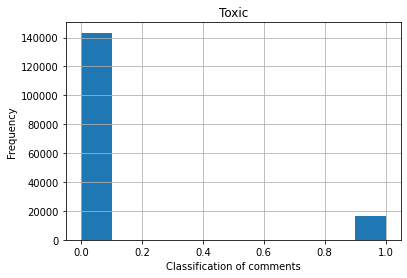

In [8]:
df['toxic'].hist()
plt.title('Toxic')
plt.xlabel('Classification of comments')
plt.ylabel('Frequency')

Явно виден дисбаланс классов. В дальнейшем в моделях сбалансируем классы.

Очистим функцией от регулярных выражений.

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

Применим функцию.

In [11]:
%%time
df['text'] = df['text'].map(lambda x: clean_text(x))

CPU times: user 8.49 s, sys: 60.9 ms, total: 8.56 s
Wall time: 8.64 s


Посмотрим на результат функции.

In [12]:
df.head(10)

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i am s...,0
2,hey man i am really not trying to edit war it ...,0
3,more i cannot make any real suggestions on imp...,0
4,you sir are my hero any chance you remember wh...,0
5,congratulations from me as well use the tools ...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word nonsense was offensive to yo...,0
9,alignment on this subject and which are contra...,0


Лемматизируем текст.

In [13]:
nlp = en_core_web_sm.load()

def lemmatize(text):
    temp = []
    for i in nlp(text):
        if i.is_stop == False:
            temp.append(i.lemma_)
    return " ".join(temp)


tqdm.pandas()
df['text'] = df['text'].progress_apply(lemmatize)

  0%|          | 0/159571 [00:00<?, ?it/s]

Посмотрим на результат лемматизации.

In [14]:
df.head()

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,d aww match background colour seemingly stuck ...,0
2,hey man try edit war guy constantly remove rel...,0
3,real suggestion improvement wonder section sta...,0
4,sir hero chance remember page,0


### Вывод

Датафрейм содержит 159571 объектов. Дубликаты и пропуски не обнаружены. По гистограмме целевого признака можно сказать о дисбалансе классов. В дальнейшем необходимо уравновесить их. Можно сказать что данных достаточно для анализа данных.

## Обучение

Разделим данные на обучающую и тестовую выборки.

In [15]:
target = df['toxic']
features = df.drop('toxic', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345)

Обучим разные модели.

### Логистическая регрессия

In [20]:
%%time
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

log_pip = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=123, solver='liblinear'))])

params = {'clf__C': [0.1, 1, 10, 50],
          'clf__class_weight': ['balanced', None]}

log_grid = GridSearchCV(estimator=log_pip, param_grid=params, cv=3, scoring='f1', n_jobs=-1)
log_grid.fit(features_train['text'], target_train)

print(log_grid.best_params_)
print(log_grid.best_score_)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'clf__C': 10, 'clf__class_weight': None}
0.7690138451850984
CPU times: user 3min 52s, sys: 2min 35s, total: 6min 27s
Wall time: 6min 28s


### LGBMClassifier

In [23]:
%%time
lgb_pip = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', LGBMClassifier(random_state=12345))])

params = {
  'clf__n_estimators': [100, 150],
  'clf__learning_rate': [0.1, 0.3],
  'clf__max_depth': [8, 10],
  'clf__class_weight': ['balanced', None]}

lgb_grid = GridSearchCV(estimator=lgb_pip, param_grid=params, cv=3, scoring='f1', n_jobs=-1)
lgb_grid.fit(features_train['text'], target_train)

print(lgb_grid.best_params_)
print(lgb_grid.best_score_)

{'clf__class_weight': None, 'clf__learning_rate': 0.3, 'clf__max_depth': 10, 'clf__n_estimators': 150}
0.7558504027733294
CPU times: user 1h 53s, sys: 15.3 s, total: 1h 1min 9s
Wall time: 1h 1min 21s


Лучшей моделью по качеству при кросс-валидации оказалась `Логистическая регрессия`, поэтому ценим её на тестовых данных.

### Лучшая модель

Создадим признаки с учетом стоп-слов.

In [ ]:
# Создадим счетчик, указав в нем стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
# Посчитаем TD-IDF для корпуса текстов
tf_idf_train = count_tf_idf.fit_transform(features_train['text'])
# Создадим признаки
tf_idf_test = count_tf_idf.transform(features_test['text'])

Обучим с найденными гиперпараметрами логистическую регрессию.

In [37]:
%%time
log_model = LogisticRegression(C=10, class_weight='balanced', random_state=123)
log_model.fit(tf_idf_train, target_train)

CPU times: user 23.4 s, sys: 21.7 s, total: 45.1 s
Wall time: 45.2 s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, class_weight='balanced', random_state=123)

Посчитаем качество модели.

In [38]:
%%time
log_pred_test = log_model.predict(tf_idf_test)
print(f'F1 тестовой выборки: {f1_score(target_test, log_pred_test)}')

F1 тестовой выборки: 0.7665684130455455
CPU times: user 18.5 ms, sys: 97 µs, total: 18.6 ms
Wall time: 16.9 ms


## Выводы

При анализе данных выявили дисбаланс классов целевого признака. Придали объектам редкого класса больший вес апсэмплингом внутри кросс-валидации. Пайплайном объединили процесс векторизации и кросс-валидации. Нашли лучшую модель по качеству при кросс-валидации и затем испытали её на тестовых данных.

Картина распределения "мест" моделей по метрике **F1** не сильно разнится. Самое низкое значение метрики при кросс-валидации у **LGBMClassifier**. Чуть повыше качество предсказаниaя у **LogisticRegression**. Лучшей моделью по качеству оказалось **LogisticRegression**. С найденными оптимальными гиперпараметрами посчитали и нашли его качество на тестовых данных. Оно получилось ниже на 0,03. 

Высокая скорость обучения с учетом поиска оптимальных гиперпараметров, у **Логистической регрессии**. Скорость у **LGBMClassifier** значительно ниже.

Цель задачи - обучить модель классифицировать комментарии на позитивные и негативные с метрикой **F1** не меньше 0.75, была достигнута.

Сравнение значений качества метрик приведено к общей таблице(см.ниже).

In [40]:
pd.DataFrame({'f1-train': [0.769, 0.756],
              'f1-test': [0.766, '-'], 
              'Скорость(мин)': [6.5, 61.5]}
             , index=['Логистическая регрессия', 'LGBMClassifier'])

,f1-train,f1-test,Скорость(мин)
Логистическая регрессия,0.769,0.766,6.5
LGBMClassifier,0.756,-,61.5
